In [4]:
import pandas as pd
import json
from collections import defaultdict
import random

# File paths
csv_path = 'rawdata_game1.csv'             # input CSV
output_path = 'structured_game1.jsonl'     # output file

# Load CSV
df = pd.read_csv(csv_path)

# Group by 'device' and collect score + time
grouped = defaultdict(list)

for _, row in df.iterrows():
    device_id = row['device']
    record = {
        'score': row['score'],
        'time': row['time']
    }
    grouped[device_id].append(record)

# Write to JSONL
with open(output_path, 'w', encoding='utf-8') as f:
    for device, records in grouped.items():
        line = json.dumps({
            'device': device,
            'records': records
        })
        f.write(line + '\n')

print(f"✅ JSONL saved to: {output_path}")


✅ JSONL saved to: structured_game1.jsonl


In [5]:
# 1. File paths
input_path  = 'structured_game1.jsonl'   
train_path  = 'train_game1.jsonl'
eval_path   = 'eval_game1.jsonl'

# 2. Read all entries
with open(input_path, 'r', encoding='utf-8') as f:
    entries = [json.loads(line) for line in f]

# 3. Shuffle with a fixed seed
random.seed(42)
random.shuffle(entries)

# 4. Split 80/20
n_total  = len(entries)
n_eval   = int(0.2 * n_total)
eval_set = entries[:n_eval]
train_set= entries[n_eval:]

# 5. Write out the two JSONL files
for path, subset in [(train_path, train_set), (eval_path, eval_set)]:
    with open(path, 'w', encoding='utf-8') as f:
        for obj in subset:
            f.write(json.dumps(obj) + '\n')

print(f"Total players: {n_total}")
print(f" → Training : {len(train_set)}")
print(f" → Evaluation: {len(eval_set)}")


Total players: 25957
 → Training : 20766
 → Evaluation: 5191


In [27]:
import json
import pandas as pd
import numpy as np  

# PARAMETERS (same as before)
OP_DAYS   = 5
CP_DAYS   = 10
S_IN_DAY  = 24 * 60 * 60
OP_S      = OP_DAYS * S_IN_DAY       # observation window length (5 days in seconds)
CP_S      = CP_DAYS * S_IN_DAY       # prediction window length (10 days in seconds)

def extract_features(input_jsonl: str, output_csv: str):
    rows = []
    with open(input_jsonl, 'r', encoding='utf-8') as f:
        for line in f:
            player = json.loads(line)  # Each line in json file is a player's data
            device = player.get('device') or player.get('uid')
            abs_recs = player['records']

            # Extracting and sorting absolute times & scores
            abs_ts_scores = sorted(
                [(r['time'], r['score'])
                 for r in abs_recs
                 if 'time' in r and 'score' in r],
                key=lambda x: x[0]
            )
            if not abs_ts_scores:
                continue

            t1_abs = abs_ts_scores[0][0]  # absolute timestamp of first play of a player

            # Computing relative times t_i = t_i^abs − t₁^abs
            rel_ts_scores = [
                (t_abs - t1_abs, score)
                for t_abs, score in abs_ts_scores
            ]

            # 4) Splitting into observation / prediction windows
            obs_recs  = [(t, s) for t, s in rel_ts_scores if t <= OP_S]
            pred_recs = [(t, s) for t, s in rel_ts_scores if OP_S < t <= OP_S + CP_S]

            if not obs_recs:
                continue

            # Computing features & label (from OP_DAYS only)
            play_count          = len(obs_recs)  # number of plays in the observation period
            active_duration_s   = obs_recs[-1][0] if play_count > 1 else 0
            churn               = 1 if len(pred_recs) == 0 else 0
            scores              = [s for t, s in obs_recs]
            mean_score          = float(np.mean(scores))               # meanScore
            sd_score            = float(np.std(scores, ddof=0))       # sdScore (population)
            best_score          = float(max(scores))                   # bestScore
            worst_score         = float(min(scores))                   # worstScore
            best_idx            = scores.index(best_score)             # index of bestScore
            best_score_index    = best_idx / (play_count - 1) if play_count > 1 else 0

            # bestSubMeanCount = (bestScore − meanScore) / n
            best_sub_mean_count = (best_score - mean_score) / play_count if play_count else 0
            # bestSubMeanRatio = (bestScore − meanScore) / meanScore
            best_sub_mean_ratio = (best_score - mean_score) / mean_score if mean_score else 0

            # consecutivePlayRatio
            C    = 3600  # threshold in seconds for defining consecutive plays
            gaps = [
                obs_recs[i+1][0] - obs_recs[i][0]
                for i in range(play_count - 1)
            ]
            consec_count            = sum(1 for g in gaps if g <= C)
            consecutive_play_ratio  = consec_count / (play_count - 1) if play_count > 1 else 0
            median_gap              = float(np.median(gaps)) if gaps else 0  # median time between plays

            rows.append({
                'device': device,
                'play_count': play_count,
                'active_duration_s': active_duration_s,
                'churn': churn,
                'mean_score': mean_score,
                'sd_score': sd_score,
                'best_score': best_score,
                'worst_score': worst_score,
                'best_score_index': best_score_index,
                'best_sub_mean_count': best_sub_mean_count,
                'best_sub_mean_ratio': best_sub_mean_ratio,
                'consecutive_play_ratio': consecutive_play_ratio,
                'median_gap': median_gap
            })

    # Saving
    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved {output_csv}, shape = {df.shape}")


extract_features('train_game1.jsonl', 'DS1_game1.csv')   # 80% split

✅ Saved DS1_game1.csv, shape = (20766, 13)


In [28]:
import pandas as pd
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from xgboost                 import XGBClassifier
from sklearn.model_selection import GridSearchCV
import joblib

# ── 1) LOAD DS1 ────────────────────────────────────────────────────────────────
df_train = pd.read_csv('DS1_game1.csv')
X_train  = df_train.drop(['device', 'churn'], axis=1)
y_train  = df_train['churn']

# ── 2) HYPERPARAMETER TUNING FOR DECISION TREE ON DS1 ──────────────────────────
base_tree = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth'        : [None, 5, 10, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf' : [1, 5, 10],
    'ccp_alpha'        : [0.0, 0.005, 0.01]
}

grid = GridSearchCV(
    estimator=base_tree,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("▶ Best Decision Tree params:", grid.best_params_)
print("▶ Best CV AUC:", grid.best_score_)

# Extracting the tuned tree
tuned_tree = grid.best_estimator_

# Defining Classifiers
models = {
    'Decision Tree (tuned)' : tuned_tree,
    'Random Forest'         : RandomForestClassifier(
                                  n_estimators=100,
                                  random_state=42
                              ),
    'XGBoost'               : XGBClassifier(
                                  n_estimators=100,
                                  eval_metric='logloss',
                                  random_state=42
                              ),
     'Logistic Regression': LogisticRegression(
                              max_iter=10000,
                              solver='lbfgs',
                              random_state=42)
}

# Training models
trained_models = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    trained_models[name] = clf
    print(f"✅ Trained: {name}")

#Saving models
for name, model in trained_models.items():
    filename = f"{name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(model, filename)
    print(f"💾 Saved {name} to: {filename}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
▶ Best Decision Tree params: {'ccp_alpha': 0.0, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
▶ Best CV AUC: 0.7810735951328125
✅ Trained: Decision Tree (tuned)
✅ Trained: Random Forest
✅ Trained: XGBoost
✅ Trained: Logistic Regression
💾 Saved Decision Tree (tuned) to: decision_tree_(tuned)_model.pkl
💾 Saved Random Forest to: random_forest_model.pkl
💾 Saved XGBoost to: xgboost_model.pkl
💾 Saved Logistic Regression to: logistic_regression_model.pkl


C:\Users\fhawk\anaconda3\envs\pt\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
extract_features('eval_game1.jsonl',  'DS2_game1.csv')   # 20% split

✅ Saved DS2_game1.csv, shape = (5191, 13)


### Performance on DS2 ###
               Accuracy  Precision(1)  Recall(1)     F1(1)   ROC-AUC
Model                                                               
Decision Tree  0.930649      0.936374   0.992736  0.963732  0.801445
Random Forest  0.931420      0.939173   0.990245  0.964033  0.775251
Logistic Reg.  0.933154      0.939454   0.991905  0.964967  0.805833
XGBoost        0.927567      0.938586   0.986509  0.961951  0.774858

### Top 5 Features per Model ###

Decision Tree:
active_duration_s    0.741436
play_count           0.174976
best_score           0.020445
sd_score             0.019303
median_gap           0.017597

Random Forest:
active_duration_s      0.177683
best_sub_mean_ratio    0.100073
mean_score             0.098570
best_score             0.096258
median_gap             0.090914

Logistic Reg.:
consecutive_play_ratio    0.275819
best_sub_mean_ratio       0.264478
best_sub_mean_count       0.007887
play_count                0.007609
sd_score                  0

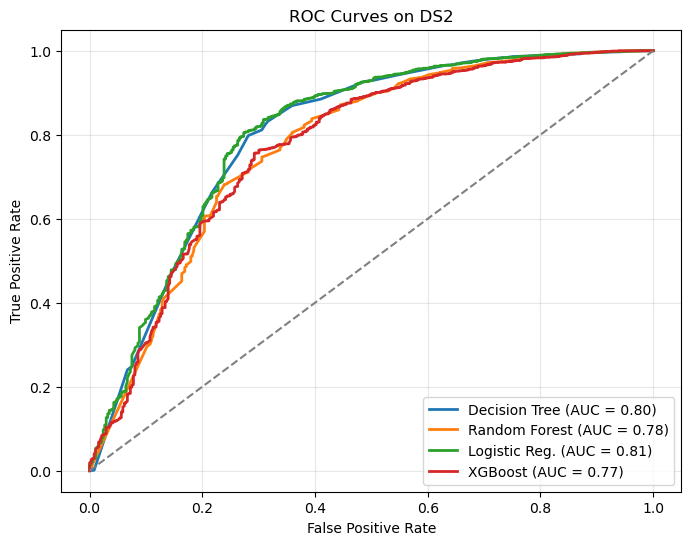

In [30]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)

# 1) Loading DS2
df_eval = pd.read_csv('DS2_game1.csv')
X_eval  = df_eval.drop(['device','churn'], axis=1)
y_eval  = df_eval['churn']

# 2) Lading Saved Models
models = {
    'Decision Tree' : joblib.load('decision_tree_(tuned)_model.pkl'),
    'Random Forest' : joblib.load('random_forest_model.pkl'),
    'Logistic Reg.' : joblib.load('logistic_regression_model.pkl'),
    'XGBoost'       : joblib.load('xgboost_model.pkl')
}

# ── 3) EVALUATE ON DS2 ──
results = []
for name, model in models.items():
    # Predictions
    y_pred = model.predict(X_eval)

    # AUC (if supported)
    if hasattr(model, 'predict_proba'):
        y_proba   = model.predict_proba(X_eval)[:,1]
        auc_score = roc_auc_score(y_eval, y_proba)
    else:
        y_proba   = None
        auc_score = None

    # Classification report
    rpt = classification_report(y_eval, y_pred, output_dict=True)
    results.append({
        'Model'       : name,
        'Accuracy'    : rpt['accuracy'],
        'Precision(1)': rpt['1']['precision'],
        'Recall(1)'   : rpt['1']['recall'],
        'F1(1)'       : rpt['1']['f1-score'],
        'ROC-AUC'     : auc_score
    })

perf_df = pd.DataFrame(results).set_index('Model')
print("### Performance on DS2 ###")
print(perf_df)

# ── 4) FEATURE IMPORTANCE ────
print("\n### Top 5 Features per Model ###")
for name, model in models.items():
    print(f"\n{name}:")
    if hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
    else:
        imp = np.abs(model.coef_[0])
    fi = pd.Series(imp, index=X_eval.columns).sort_values(ascending=False).head(5)
    print(fi.to_string())

# ── 4.1) TOP-5 FEATURES BY |Pearson r| WITH CHURN ─────────────────────────────
print("\n### Top 5 Features by |Pearson r| with churn ###")
# drop the non-numeric 'device' column, then compute
corrs = df_eval.drop(columns=['device']).corr(numeric_only=True)['churn'] \
               .abs() \
               .sort_values(ascending=False)
# skiping the 1.0 self-correlation
top5_corr = corrs.iloc[1:6]
print(top5_corr.to_string())

# ── 5) PLOT ROC CURVES ──────────────────────────────────────────────────────────
plt.figure(figsize=(8,6))
for name, model in models.items():
    if not hasattr(model, 'predict_proba'):
        continue
    probs     = model.predict_proba(X_eval)[:,1]
    fpr, tpr, _ = roc_curve(y_eval, probs)
    roc_auc    = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

# random‐chance line
plt.plot([0,1], [0,1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on DS2')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
